# Define Paths

In [11]:
pathTo95TVA2DVASample = "localData/95TVA2DVASample/"
gold_standard_path = "localData/gold_standards/"
gold_standard_path_with_missing_values = "localData/artificialMissingData/"

#ALL Pair sample can be found in https://drive.google.com/file/d/16J1yGQmjwUJu-k58x0DvIcRWy2r4OgsM/view?usp=sharing
allPairsSamplePath = "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/csvFiles/"
allPairsSampleRootPath = "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/"

leanPDFPlotHeight = 2
leanPDFPlotWidth = 6

# Blocking Recall with Missing Values Plot:

Processing 0.0
Processing 0.1
Processing 0.2
Processing 0.3
Processing 0.4
Processing 0.5
Processing 0.0
Processing 0.1
Processing 0.2
Processing 0.3
Processing 0.4
Processing 0.5
Empty DataFrame
Columns: [recall, method, dataset, missingValuePercentage, GS]
Index: []


/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


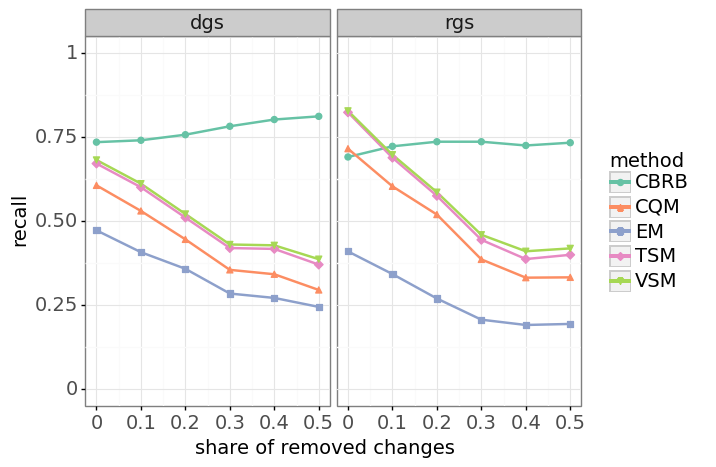

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exported_plots_new/missingDataRecallNonParametrized.pdf
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [26]:
#getRecallForNonparametrizedMethodsDF

import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

goldStandardType = [True,False]
#methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']
methodNames = ['isInExactMatchBlockingWithDVAFilter','isInStrictBlockingNoDecayWithDVAFilter','isInSequenceBlockingWithDVAFilter','isInTSMBlockingWithDVAFilter','isInValueSetBlockingWithDVAFilter']

methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithDVAFilter':"EM",
    'isInStrictBlockingNoDecayWithDVAFilter':"CBRB",
    'isInSequenceBlockingWithDVAFilter':"CQM",
    'isInTSMBlockingWithDVAFilter':"TSM",
    'isInValueSetBlockingWithDVAFilter':"VSM"
}

missingValuePercentages = [0.0,0.1,0.2,0.3,0.4,0.5]

finalDFRows = []
for weighted in goldStandardType:
    if(weighted):
        gsName = "rgs"
    else:
        gsName = "dgs"
    for missingValuePercentage in missingValuePercentages:
        print("Processing",missingValuePercentage)
        df = rm.readGoldStandardEvaluation(gold_standard_path_with_missing_values,not weighted,pathTo95TVA2DVASample,missingValuePercentage)
        #print(missingValuePercentage,sum(df["hasTransitionOverlapNoDecay"]))
        dsNameList = []
        for dsName in df['dataset'].unique():
            dsNameList.append(dsName)
        dsNameList.sort()
        for dsName in dsNameList:
            shortName = rm.datasetToAbbreviation[dsName]
            recallValues = mhm.getRecallForNonparametrizedMethodsDF(df[df['dataset']==dsName],methodNames,weighted,bucketAndDatasetToWeight)
            for i in range(0,len(recallValues)):
                method = methodNames[i]
                recall = recallValues[i]
                finalDFRows.append({"recall":recall,"method":methodNamesToShortMethodName[method],"dataset":shortName,"missingValuePercentage":missingValuePercentage,"GS":gsName})
        miaRecallValues = mhm.getRecallForNonparametrizedMethodsDF(df,methodNames,weighted,bucketAndDatasetToWeight)
        maaRecallValues = mhm.getMacroAveragesRecall(df,methodNames,weighted,bucketAndDatasetToWeight)
        #mhm.printRecallForNonparametrizedMethodsDF(shortName,df,methodNames,~weighted,bucketAndDatasetToWeight)
        for i in range(0,len(miaRecallValues)):
            method = methodNames[i]
            recallMia = miaRecallValues[i]
            recallMaa = maaRecallValues[i]
            finalDFRows.append({"recall":recallMia,"method":methodNamesToShortMethodName[method],"dataset":"MIA","missingValuePercentage":missingValuePercentage,"GS":gsName})
            finalDFRows.append({"recall":recallMaa,"method":methodNamesToShortMethodName[method],"dataset":"MAA","missingValuePercentage":missingValuePercentage,"GS":gsName})

finalDf = pd.DataFrame(finalDFRows)
finalDF01 = finalDf[(finalDf["method"]=="isInStrictBlockingNoDecayWithFilter") & (finalDf["missingValuePercentage"]==0.0) & (finalDf["GS"]=="rgs")]
print(finalDF01)
#finalDFMia = finalDf[(finalDf["dataset"]=="MIA") | (finalDf["dataset"]=="MAA")]
finalDFMaa = finalDf[(finalDf["dataset"]=="MAA")]
#print(finalDFMia)
plot = ggplot(finalDFMaa, aes(x ='missingValuePercentage', y='recall', color="method", shape = "method")) + geom_line(size=1) + geom_point(size=2) + theme_bw() + theme(text=element_text(size=14)) +facet_wrap("GS") + xlab("share of removed changes") + ylim(0,1) + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exported_plots_new/missingDataRecallNonParametrized.pdf",width=leanPDFPlotWidth,height=leanPDFPlotHeight)

# Impact of TVA on recall

In [7]:

#getRecallForNonparametrizedMethodsDF

import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

methodNames = ['isInExactMatchBlockingWithDVAFilter','isInStrictBlockingNoDecayWithDVAFilter','isInSequenceBlockingWithDVAFilter','isInTSMBlockingWithDVAFilter','isInValueSetBlockingWithDVAFilter','isInRM0.88']

methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithDVAFilter':"EM",
    'isInStrictBlockingNoDecayWithDVAFilter':"CBRB",
    'isInSequenceBlockingWithDVAFilter':"CQM",
    'isInTSMBlockingWithDVAFilter':"TSM",
    'isInValueSetBlockingWithDVAFilter':"VSM",
    'isInRM0.88':"RM"
}



bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

dgs = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
rgs = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
rgsRMSetting=0.88
dgsRMSetting=0.9


rm.addRMMethodWithParameter(rgs,rgsRMSetting)
rm.addRMMethodWithParameter(dgs,dgsRMSetting)
print(dgs["VACount"].describe())
print(dgs["DVACount"].describe())
print(rgs)

count    1500.000000
mean      475.347333
std       174.127740
min       103.000000
25%       324.000000
50%       466.000000
75%       670.250000
max       697.000000
Name: VACount, dtype: float64
count    1500.000000
mean        1.763333
std         2.385606
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        81.000000
Name: DVACount, dtype: float64
          dataset                                                id1  \
0     tv_and_film  infobox television episode||4087244||228832498...   
1     tv_and_film         infobox film||1161730||41838890-0||country   
2     tv_and_film         infobox actor||7150501||227250242-0||image   
3     tv_and_film   infobox actor||11372885||301977019-0||birth_date   
4     tv_and_film         infobox actor||2499552||167935863-0||image   
...           ...                                                ...   
1495     military  infobox military person||27019701||357033141-0...   
1496     military  infobox 

In [8]:


#GSList = [dgs,rgs]
GSList = [rgs]
#nameList = ["dgs","rgs"]
nameList = ["rgs"]
finalDFRows=[]
extraFilterAttribute="VACount"
for i in range(0,len(GSList)):
    gsName=nameList[i]
    curDF=GSList[i]
    _,r,thresholds=precision_recall_curve(curDF["isSemanticRoleMatch"],curDF[extraFilterAttribute])
    rNew = r[0:len(r)-1]
    tmpDF = pd.DataFrame({"r":rNew,"thresholds":thresholds})
    # print(tmpDF)
    # plot = ggplot(tmpDF, aes(x ='thresholds', y='r')) + geom_line() + theme_bw() + theme(text=element_text(size=14)) + ylim(0,1) + scale_color_brewer(type="qual",palette="Set2")
    # print(plot)
    weighted = gsName=="rgs"
    if(extraFilterAttribute=="VACount"):
        thresholds = [95] + list(thresholds)
    for threshold in thresholds:
        df = curDF
        #print(missingValuePercentage,sum(df["hasTransitionOverlapNoDecay"]))
        dsNameList = []
        for dsName in df['dataset'].unique():
            dsNameList.append(dsName)
        dsNameList.sort()
        methodNamesNew = []
        for methodName in methodNames:
            methodNameNew = methodName + "_cur"
            df[methodNameNew] = (df[methodName]) & (df[extraFilterAttribute]>=threshold)
            methodNamesNew.append(methodNameNew)
        for dsName in dsNameList:
            shortName = rm.datasetToAbbreviation[dsName]
            recallValues = mhm.getRecallForNonparametrizedMethodsDF(df[df['dataset']==dsName],methodNamesNew,weighted,bucketAndDatasetToWeight)
            for i in range(0,len(recallValues)):
                method = methodNames[i]
                recall = recallValues[i]
                finalDFRows.append({"recall":recall,"method":methodNamesToShortMethodName[method],"dataset":shortName,"TVAThreshold":threshold,"GS":gsName})
        miaRecallValues = mhm.getRecallForNonparametrizedMethodsDF(df,methodNamesNew,weighted,bucketAndDatasetToWeight)
        maaRecallValues = mhm.getMacroAveragesRecall(df,methodNamesNew,weighted,bucketAndDatasetToWeight)
        #mhm.printRecallForNonparametrizedMethodsDF(shortName,df,methodNames,~weighted,bucketAndDatasetToWeight)
        for i in range(0,len(miaRecallValues)):
            method = methodNames[i]
            recallMia = miaRecallValues[i]
            recallMaa = maaRecallValues[i]
            finalDFRows.append({"recall":recallMia,"method":methodNamesToShortMethodName[method],"dataset":"MIA","TVAThreshold":threshold,"GS":gsName})
            finalDFRows.append({"recall":recallMaa,"method":methodNamesToShortMethodName[method],"dataset":"MAA","TVAThreshold":threshold,"GS":gsName})



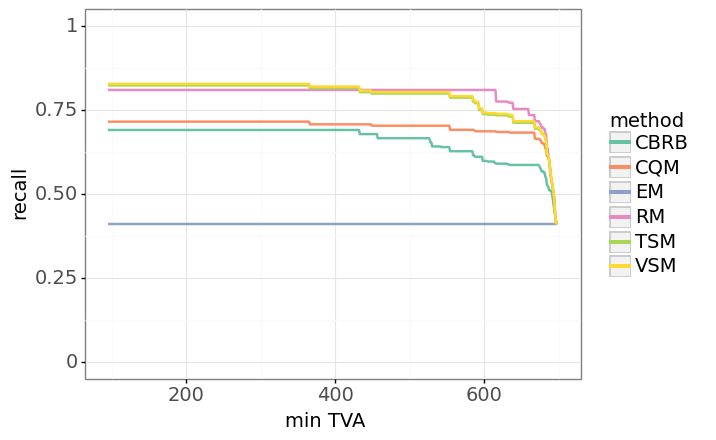

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exported_plots_new/TVAImpact.pdf


In [17]:
finalDf = pd.DataFrame(finalDFRows)
#finalDFMia = finalDf[(finalDf["dataset"]=="MIA") | (finalDf["dataset"]=="MAA")]
finalDFMaa = finalDf[(finalDf["dataset"]=="MAA")]
#print(finalDFMaa[finalDFMaa["GS"]=="rgs"])
if(extraFilterAttribute=="DVACount"):
    xmin=2
    xmax=21
    xlabel="min DVA"
    fname="exported_plots_new/DVAImpact.pdf"
else:
    xmin=95
    xmax=700
    xlabel="min TVA"
    fname="exported_plots_new/TVAImpact.pdf"
finalDFMaaRGS = finalDFMaa[finalDFMaa["GS"]=="rgs"]
# plot = ggplot(finalDFMaa, aes(x ='TVAThreshold', y='recall', color="method", shape = "method")) + geom_line() + theme_bw() + theme(text=element_text(size=14)) +facet_wrap("GS") + xlab(xlabel) + ylim(0,1) + xlim(xmin,xmax) + scale_color_brewer(type="qual",palette="Set2")
plot = ggplot(finalDFMaaRGS, aes(x ='TVAThreshold', y='recall', color="method", shape = "method")) + geom_line(size=1) + theme_bw() + theme(text=element_text(size=14)) + xlab(xlabel) + ylim(0,1) + xlim(xmin,xmax) + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save(fname,height=leanPDFPlotHeight,width=leanPDFPlotWidth)
#TODO: this is not working, previos cell rertuns wrong recall values for dgs - investiate!

In [20]:
df["isInStrictBlockingNoDecayWithFilter"]

4        True
14       True
25       True
38       True
46       True
        ...  
1454     True
1465     True
1474     True
1485     True
1494    False
Name: isInStrictBlockingNoDecayWithFilter, Length: 268, dtype: bool

# Print How Many True Positives could correct Data quality errors (Introduction):

In [ ]:
df1 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
df2 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
dfAll = df1.append(df2)
dfAllTP = dfAll[dfAll['isSemanticRoleMatch']]
print(sum(dfAllTP["hasNonOverlap"]) / len(dfAllTP.index))
print(sum(~ dfAllTP["isInStrictBlockingNoDecay"]) / len(dfAllTP.index))
print(sum( dfAllTP["compatibilityPercentageNoDecay"] != 1.0) / len(dfAllTP.index))

# Gold Standard Overview (Figure 6)

In [ ]:
# true positives:
dfTruePositivesOnly = df[df['isSemanticRoleMatch']]
tab = dfTruePositivesOnly.groupby(['dataset','bucket']).size()
print(tab)

In [ ]:
import role_matching.EvaluationHelperMethods as rm
loadDiverseGoldStandard=True # old or new gold standard

df1 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
df1["GS"] = "DGS"
df2 = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
df2["GS"] = "RGS"

rm.addShortDataset(df1)
rm.addShortDataset(df2)
df1['bucket'] = df1['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))
df2['bucket'] = df2['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))

dfTruePositivesOnlyDF1 = df1[df1['isSemanticRoleMatch']]
dfTruePositivesOnlyDF2 = df2[df2['isSemanticRoleMatch']]
dfAllPositives = pd.concat([dfTruePositivesOnlyDF1,dfTruePositivesOnlyDF2])

cbPalette = ["#1b9e77", "#d95f02", "#7570b3", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plot = ggplot(dfAllPositives,aes(x = 'datasetShort',fill="bucket")) +xlab("") + geom_bar(stat = "count") + facet_wrap("GS") + theme_bw() + ggtitle("True Positives") + theme(text=element_text(size=14)) +  geom_text(aes(label = "..count.."),position = position_stack(vjust = 0.25), stat = "count")+ scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/truePositivesBoth.png")


# Reduction Ratios of Non-Parametrized Methods (Table 4 and Figure 7)

dataset,#Total Pairs,EM,CBRB,QSM,TSM,VSM
education,2737889001,0.9999997666493209,0.9999987665749821,0.9999974331425303,0.9999956996803429,0.9999935328526087,
football,53116323211,0.9999997212833553,0.9999979476319804,0.9999633614301671,0.9999550252687044,0.999934197533986,
military,4263199291,0.9999994847723459,0.9999925403996164,0.9999904794889999,0.9999828070771939,0.9999821238405222,
politics,2223411270,0.9999991674967319,0.9999982636360408,0.9999964559146586,0.9999953141958909,0.9999948622655453,
tv_and_film,23657801481,0.9999999612753896,0.9999998063769481,0.9999990706093509,0.9999980250448707,0.9999968052196437,


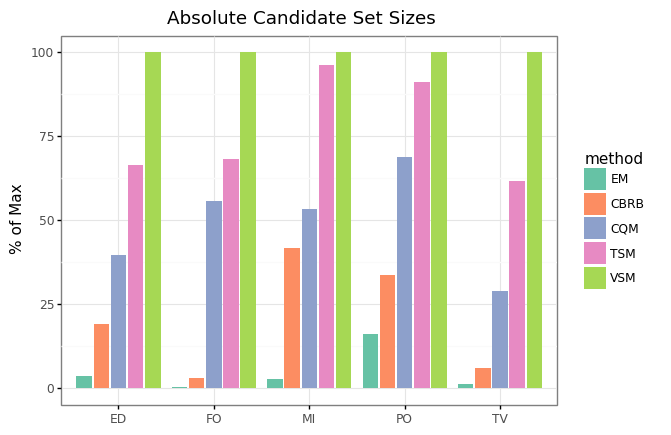

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/absoluteSetSizes.png


In [12]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm


#Statistics extracted from the sample drawing:
#We drew a sample from the set of all pairs until we had 1 million candidate pairs that had at least one timestamp-value agreement (1TVA)
#Having 1TVA is a prerequisite for a candidate pair in order to be considered
#We tracked how many candidate pairs did not have 1TVA per dataset in order to be able to compute the correct (estimated) reduction ratio
#allPairs denotes the number of all pairs per dataset, nMisses1TVA denotes how many pairs we had to skip (because they were not in 1TVA)

methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithFilter':"EM",
    'isInStrictBlockingNoDecayWithFilter':"CBRB",
    'isInSequenceBlockingWithFilter':"CQM",
    'isInTSMBlockingWithFilter':"TSM",
    'isInValueSetBlockingWithFilter':"VSM"
}

#load this from somewhere:
dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88280922,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50646743,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41041877,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28997770,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38466606,"nHits1TVA":1000000},
}

methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']

#these are the files that contain the statistics about the 1 million candidates in TVA (per dataset):
dfAllPairsSample = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', allPairsSamplePath  +"/*.csv"))))
rm.addFilteredBlockingMethods(dfAllPairsSample)
rm.addDVA2VA95Blocking(dfAllPairsSample)
#rm.addParametrizedScoresAsBooleanScores(dfAllPairsSample)
#print(dfAllPairsSample.columns)
groupedByDS = dfAllPairsSample.groupby("dataset")

print("dataset","#Total Pairs","EM","CBRB","QSM","TSM","VSM",sep=",")
finalDSRows = []
for (ds,thisDsAllPairsSample) in groupedByDS:
    nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
    nHits1TVA = dsToBaseSampleStatistics[ds]["nHits1TVA"]
    nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
    estimatedCountSVAPairs = round((nHits1TVA / (nHits1TVA+nMisses1TVA)) * nAllPairs)
    nHits90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    nMisses90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    print(ds,nAllPairs,sep=",",end=",")
    for method in methodNames:
        thisDF = thisDsAllPairsSample[thisDsAllPairsSample[method]]
        nHitsThisMethod = len(thisDF.index)
        nMissesThisMethod = nMisses1TVA + len(thisDsAllPairsSample.index) - nHitsThisMethod
        n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
        finalDSRows.append({"dataset":ds,"method":methodNamesToShortMethodName[method],"n":n,"rr":rrAll})
        _,rr1VA = mhm.getReductionRate(nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        rr95 = mhm.getReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
        print(rrAll,sep=",",end=",")
    print("")
finalDF = pd.DataFrame(finalDSRows)
#get maxima:
grouped = finalDF.groupby("dataset",).agg({'n':"max"}).to_dict("index")
finalDF["% of Max"] = finalDF.apply(lambda r: 100*(r["n"] / grouped[r["dataset"]]["n"]),axis=1)
finalDF['method'] = finalDF['method'].astype("category").cat.reorder_categories(['EM', 'CBRB', "CQM", "TSM", "VSM"])
rm.addShortDataset(finalDF)
plot = ggplot(finalDF,aes(x = 'datasetShort',fill="method",y="% of Max")) +xlab("") + geom_bar(position=position_dodge2(preserve = "single"),stat="identity") + ggtitle("Absolute Candidate Set Sizes") + theme(text=element_text(size=14)) + theme_bw() + scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/absoluteSetSizes.png")



# With Missing Values:

In [50]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm


#Statistics extracted from the sample drawing:
#We drew a sample from the set of all pairs until we had 1 million candidate pairs that had at least one timestamp-value agreement (1TVA)
#Having 1TVA is a prerequisite for a candidate pair in order to be considered
#We tracked how many candidate pairs did not have 1TVA per dataset in order to be able to compute the correct (estimated) reduction ratio
#allPairs denotes the number of all pairs per dataset, nMisses1TVA denotes how many pairs we had to skip (because they were not in 1TVA)

missingValuePercentages = [0.0,0.1,0.2,0.3,0.4,0.5]
methodNames = ['isInExactMatchBlockingWithDVAFilter','isInStrictBlockingNoDecayWithDVAFilter','isInSequenceBlockingWithDVAFilter','isInTSMBlockingWithDVAFilter','isInValueSetBlockingWithDVAFilter']
methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithDVAFilter':"EM",
    'isInStrictBlockingNoDecayWithDVAFilter':"CBRB",
    'isInSequenceBlockingWithDVAFilter':"CQM",
    'isInTSMBlockingWithDVAFilter':"TSM",
    'isInValueSetBlockingWithDVAFilter':"VSM"
}


dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88180876,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50584136,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41017799,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28976763,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38500828,"nHits1TVA":1000000},
}


finalDSRows = []
for mv in missingValuePercentages:
    #these are the files that contain the statistics about the 1 million candidates in TVA (per dataset):
    rootPath = allPairsSampleRootPath + str(mv)
    print("Processing ",rootPath)
    dfAllPairsSample = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', rootPath + "/*.csv"))))
    rm.addFilteredBlockingMethods(dfAllPairsSample)
    rm.addDVA2VA95Blocking(dfAllPairsSample)
    #rm.addParametrizedScoresAsBooleanScores(dfAllPairsSample)
    #print(dfAllPairsSample.columns)
    groupedByDS = dfAllPairsSample.groupby("dataset")
    rrValues = {}
    for k in methodNames:
        rrValues[k]=[]
    print(rrValues)
    for (ds,thisDsAllPairsSample) in groupedByDS:
        nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
        nHits1TVA = dsToBaseSampleStatistics[ds]["nHits1TVA"]
        nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
        estimatedCountSVAPairs = round((nHits1TVA / (nHits1TVA+nMisses1TVA)) * nAllPairs)
        nHits90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
        nMisses90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
        for method in methodNames:
            thisDF = thisDsAllPairsSample[thisDsAllPairsSample[method]]
            nHitsThisMethod = len(thisDF.index)
            nMissesThisMethod = nMisses1TVA + len(thisDsAllPairsSample.index) - nHitsThisMethod
            n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
            finalDSRows.append({"dataset":ds,"method":methodNamesToShortMethodName[method],"n":n,"rr":rrAll,"mv":mv})
            rrValues[method].append(rrAll)
            # _,rr1VA = mhm.getReductionRate(nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
            # rr95 = mhm.getReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
    for k in methodNames:
        maaRecall = sum(rrValues[k]) / len(rrValues[k])
        finalDSRows.append({"dataset":"MAA","method":methodNamesToShortMethodName[k],"n":-1,"rr":maaRecall,"mv":mv})
finalDFRR = pd.DataFrame(finalDSRows)
print(finalDFRR)
#get maxima:





Processing  /home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/0.0
{'isInExactMatchBlockingWithDVAFilter': [], 'isInStrictBlockingNoDecayWithDVAFilter': [], 'isInSequenceBlockingWithDVAFilter': [], 'isInTSMBlockingWithDVAFilter': [], 'isInValueSetBlockingWithDVAFilter': []}
Processing  /home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/0.1
{'isInExactMatchBlockingWithDVAFilter': [], 'isInStrictBlockingNoDecayWithDVAFilter': [], 'isInSequenceBlockingWithDVAFilter': [], 'isInTSMBlockingWithDVAFilter': [], 'isInValueSetBlockingWithDVAFilter': []}
Processing  /home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/0.2
{'isInExactMatchBlockingWithDVAFilter': [], 'isInStrictBlockingNoDecayWithDVAFilter': [], 'isInSequenceBlockingWithDVAFilter': [], 'isInTSMBlockingWithDVAFilter': [], 'isInValueSetBlockingWithDVAFilter': []}
Processing  /home/leon/data/dataset_versioning/finalExp

    dataset method    n        rr   mv
25      MAA     EM -1.0  1.000000  0.0
26      MAA   CBRB -1.0  0.999948  0.0
27      MAA    CQM -1.0  0.999988  0.0
28      MAA    TSM -1.0  0.999981  0.0
29      MAA    VSM -1.0  0.999971  0.0
55      MAA     EM -1.0  1.000000  0.1
56      MAA   CBRB -1.0  0.999244  0.1
57      MAA    CQM -1.0  0.999974  0.1
58      MAA    TSM -1.0  0.999950  0.1
59      MAA    VSM -1.0  0.999940  0.1
85      MAA     EM -1.0  0.999999  0.2
86      MAA   CBRB -1.0  0.998545  0.2
87      MAA    CQM -1.0  0.999928  0.2
88      MAA    TSM -1.0  0.999851  0.2
89      MAA    VSM -1.0  0.999839  0.2
115     MAA     EM -1.0  0.999999  0.3
116     MAA   CBRB -1.0  0.997881  0.3
117     MAA    CQM -1.0  0.999850  0.3
118     MAA    TSM -1.0  0.999683  0.3
119     MAA    VSM -1.0  0.999668  0.3
145     MAA     EM -1.0  0.999999  0.4
146     MAA   CBRB -1.0  0.997219  0.4
147     MAA    CQM -1.0  0.999737  0.4
148     MAA    TSM -1.0  0.999440  0.4
149     MAA    VSM -1.0  

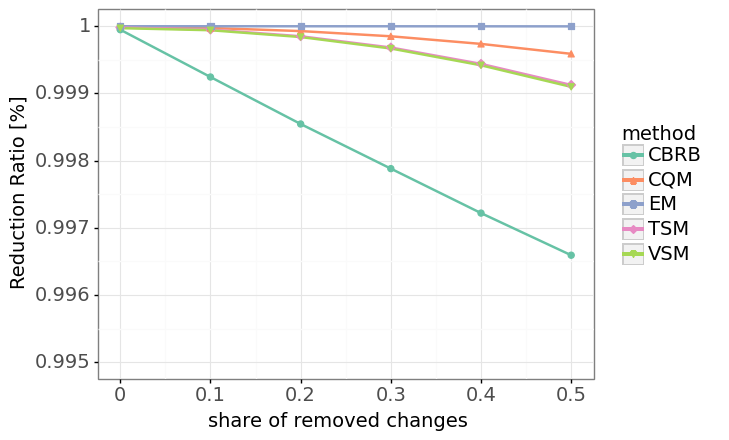

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exported_plots_new/missingDataReductionRatioNonParametrized.pdf


In [51]:
finalDFMaa = finalDFRR[(finalDFRR["dataset"]=="MAA")]
print(finalDFMaa)
#print(finalDFMia)
plot = ggplot(finalDFMaa, aes(x ='mv', y='rr', color="method", shape = "method")) + geom_line(size=1) + geom_point(size=2) + theme_bw() + theme(text=element_text(size=14)) + xlab("share of removed changes") + ylab("Reduction Ratio [%]") + ylim(0.995,1.0) + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exported_plots_new/missingDataReductionRatioNonParametrized.pdf",width=leanPDFPlotWidth,height=leanPDFPlotHeight)

# grouped = finalDF.groupby("dataset",).agg({'n':"max"}).to_dict("index")
# finalDF["% of Max"] = finalDF.apply(lambda r: 100*(r["n"] / grouped[r["dataset"]]["n"]),axis=1)
# finalDF['method'] = finalDF['method'].astype("category").cat.reorder_categories(['EM', 'CBRB', "CQM", "TSM", "VSM"])
# rm.addShortDataset(finalDF)
# plot = ggplot(finalDF,aes(x = 'datasetShort',fill="method",y="% of Max")) +xlab("") + geom_bar(position=position_dodge2(preserve = "single"),stat="identity") + ggtitle("Absolute Candidate Set Sizes") + theme(text=element_text(size=14)) + theme_bw() + scale_fill_brewer(type="qual",palette="Set2")
# print(plot)
# plot.save("exportedPlots/absoluteSetSizes.png")

In [24]:
finalCBRB= finalDFRR[(finalDFRR["method"]=="CBRB")]
print(finalCBRB)

         dataset method             n        rr   mv
1      education   CBRB  2.180136e+05  0.999920  0.0
6       football   CBRB  1.532945e+06  0.999971  0.0
11      military   CBRB  6.893331e+04  0.999984  0.0
16      politics   CBRB  1.779034e+05  0.999920  0.0
21   tv_and_film   CBRB  1.280024e+06  0.999946  0.0
26           MAA   CBRB -1.000000e+00  0.999948  0.0
31     education   CBRB  3.810990e+06  0.998608  0.1
36      football   CBRB  2.462125e+07  0.999536  0.1
41      military   CBRB  1.659323e+06  0.999611  0.1
46      politics   CBRB  2.123570e+06  0.999045  0.1
51   tv_and_film   CBRB  1.372483e+07  0.999420  0.1
56           MAA   CBRB -1.000000e+00  0.999244  0.1
61     education   CBRB  7.406433e+06  0.997295  0.2
66      football   CBRB  4.737608e+07  0.999108  0.2
71      military   CBRB  3.332223e+06  0.999218  0.2
76      politics   CBRB  3.996106e+06  0.998203  0.2
81   tv_and_film   CBRB  2.602608e+07  0.998900  0.2
86           MAA   CBRB -1.000000e+00  0.99854

# Reduction Ratio parametrized (Figure 8):

In [29]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm

#same as above
dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88280922,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50646743,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41041877,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28997770,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38466606,"nHits1TVA":1000000},
}
allPairsSamplePath = "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/csvFilesNew/"
dfAllPairsParametrized = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', allPairsSamplePath+"*.csv"))))
print(dfAllPairsParametrized.columns)
groupedByDsParametrized = dfAllPairsParametrized.groupby("dataset")

Index(['dataset', 'id1', 'id2', 'RM_Gamma', 'CBRB_Beta', 'Relaxed_CBRB_Gamma',
       'hasTransitionOverlap'],
      dtype='object')


# Normal

In [31]:
#oldGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
#newGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
pd.options.mode.chained_assignment = None

thresholds = []
for i in range(101):
    thresholds.append(i/100)
finalDFRows = []
methods = ["RM_Gamma","CBRB_Beta"]

methodsToRecallScoreNames = {
    "RM_Gamma":"exactSequenceMatchPercentage",
    "CBRB_Beta":"decayScore",
    "Relaxed_CBRB_Gamma":"compatibilityPercentageNoDecay"
}

methodsToPlotNames = {
    "RM_Gamma":"RM",
    "CBRB_Beta":"CBRB"
}

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

def getRecall(goldStandard, ds, scoreName, weighted, threshold):
    goldStandardThisDS = goldStandard[goldStandard["dataset"] == ds]
    goldStandardThisDS['currentScoreWithCutoff'] = ((goldStandardThisDS[scoreName] !=-1) & (goldStandardThisDS[scoreName]>=threshold) & (goldStandardThisDS['DVACount'] > 0))
    recallDGS = mhm.getRecall(goldStandardThisDS,'currentScoreWithCutoff',weighted,bucketAndDatasetToWeight)
    return recallDGS

#goldStandardMissingValues=[0.0,0.1,0.2,0.3,0.4,0.5]
goldStandardMissingValues=[0.0]

def readAllArtificialMissingValueGoldStandards(goldStandardMissingValues):
    goldStandardMap = {}
    # basePath="localData/artificialMissingData/"
    for gs in goldStandardMissingValues:
        dgsGS = rm.readGoldStandardEvaluation(gold_standard_path_with_missing_values,True,pathTo95TVA2DVASample,gs)
        rgsGS = rm.readGoldStandardEvaluation(gold_standard_path_with_missing_values,False,pathTo95TVA2DVASample,gs)
        # dgsPath = basePath + "dgs_cleaned_" + gs + ".csv"
        # rgsPath = basePath + "rgs_cleaned_" + gs + ".csv"
        # if gs == "normal":
        #     dgsGS = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample) #TODO: think about whether we need to change the samples!
        #     rgsGS = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
        # else :
        #     dgsGS = rm.readGoldStandard(dgsPath,pathTo95TVA2DVASample)
        #     rgsGS = rm.readGoldStandard(rgsPath,pathTo95TVA2DVASample)
        goldStandardMap[("dgs",gs)]=dgsGS
        goldStandardMap[("rgs",gs)]=rgsGS
    return goldStandardMap



goldStandardMap = readAllArtificialMissingValueGoldStandards(goldStandardMissingValues)

for method in methods:
    print("processing",method)
    plotnameMethod = methodsToPlotNames[method]
    for t in thresholds:
    #print("Processing ",ds)
        print("processing",t)
        for gs in goldStandardMissingValues:
            print("processing",gs)
            avgN = 0
            avgRR = 0
            avgRecallDGS = 0
            avgRecallRGS = 0
            for(ds,dfGrouped) in groupedByDsParametrized:
                scoreName = methodsToRecallScoreNames[method]
                #recall old and new gold standard:
                dgsGS = goldStandardMap[("dgs",gs)]
                rgsGS = goldStandardMap[("rgs",gs)]
                recallDGS = getRecall(dgsGS,ds,scoreName,False,t)
                recallRGS = getRecall(rgsGS,ds,scoreName,True,t)
                #recall new gold standard:
                #reduction ratio:
                nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
                nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
                thisDF = dfGrouped[((dfGrouped[method]>=t) & (dfGrouped["hasTransitionOverlap"]))]
                nHitsThisMethod = len(thisDF.index)
                nMissesThisMethod = nMisses1TVA + len(dfGrouped.index) - nHitsThisMethod
                n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
                if(rrAll>1):
                    print(n,rrAll,nHitsThisMethod,nMissesThisMethod,nAllPairs)
                avgN +=n
                avgRR += rrAll
                avgRecallDGS += recallDGS
                avgRecallRGS += recallRGS
                finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":ds,"recall":recallDGS,"GS":"DGS"})
                finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":ds,"recall":recallRGS,"GS":"RGS"})
            avgN = avgN / len(groupedByDsParametrized)
            avgRR = avgRR / len(groupedByDsParametrized)
            avgRecallDGS = avgRecallDGS / len(groupedByDsParametrized)
            avgRecallRGS = avgRecallRGS / len(groupedByDsParametrized)
            finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":"MAA","recall":avgRecallDGS,"GS":"DGS"})
            finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":"MAA","recall":avgRecallRGS,"GS":"RGS"})
finalDF = pd.DataFrame(finalDFRows)
print(finalDF.describe())

processing RM_Gamma
processing 0.0
processing 0.0
processing 0.01
processing 0.0
processing 0.02
processing 0.0
processing 0.03
processing 0.0
processing 0.04
processing 0.0
processing 0.05
processing 0.0
processing 0.06
processing 0.0
processing 0.07
processing 0.0
processing 0.08
processing 0.0
processing 0.09
processing 0.0
processing 0.1
processing 0.0
processing 0.11
processing 0.0
processing 0.12
processing 0.0
processing 0.13
processing 0.0
processing 0.14
processing 0.0
processing 0.15
processing 0.0
processing 0.16
processing 0.0
processing 0.17
processing 0.0
processing 0.18
processing 0.0
processing 0.19
processing 0.0
processing 0.2
processing 0.0
processing 0.21
processing 0.0
processing 0.22
processing 0.0
processing 0.23
processing 0.0
processing 0.24
processing 0.0
processing 0.25
processing 0.0
processing 0.26
processing 0.0
processing 0.27
processing 0.0
processing 0.28
processing 0.0
processing 0.29
processing 0.0
processing 0.3
processing 0.0
processing 0.31
process

KeyboardInterrupt: 

In [ ]:
finalDF[finalDF]

In [27]:
from plotnine import *

#we can never get worse in terms of reduction ratio if we choose less recall:
def createSmoothedRR(x, finalDF):
    gs = x["GS"]
    method = x["method"]
    dataset = x["dataset"]
    recall = x["recall"]
    synthData = x["gs"]
    sorted = finalDF[(finalDF["dataset"]==dataset) & (finalDF["method"]==method) & (finalDF["GS"]==gs)  & (finalDF["gs"]==synthData) & (finalDF["recall"]>=recall)].sort_values('rr',ascending=False)
    bestRR = sorted.iloc[0]["rr"]
    return bestRR

reductionRatioSmoothed = finalDF.apply(lambda x: createSmoothedRR(x,finalDF),axis=1)
finalDF["rrSmooth"] = reductionRatioSmoothed
finalDFMAA = finalDF[finalDF['dataset']=="MAA"]
plot = ggplot(finalDFMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["GS","gs"]) + theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/rrParametrizedMissing.png")

#faceted by dataset:
# finalDFNOMAA = finalDF[finalDF['dataset']!="MAA"]
# finalDFNOMAADGS = finalDFNOMAA[finalDFNOMAA["GS"]=="DGS"]
# finalDFNOMAARGS = finalDFNOMAA[finalDFNOMAA["GS"]=="RGS"]
# plot = ggplot(finalDFNOMAADGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("DGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45)) + scale_color_brewer(type="qual",palette="Set2")
# print(plot)
# plot.save("exportedPlots/rrDGSAll.png")
#
# plot = ggplot(finalDFNOMAARGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("RGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45))
# print(plot)
# plot.save("exportedPlots/rrRGSAll.png")
#
# plot = ggplot(finalDFNOMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset","GS"]) +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + ylim(99.95,100)
# print(plot)
# for ds in finalDFNOMAA["dataset"].unique():
#     thisDF = finalDFNOMAA[finalDFNOMAA["dataset"]==ds]
#     plot = ggplot(thisDF, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap("GS") +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]")
#     print(plot)

NameError: name 'finalDF' is not defined

# With Missing Values

In [47]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm

#same as above
dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88180876,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50584136,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41017799,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28976763,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38500828,"nHits1TVA":1000000},
}



In [33]:
#oldGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
#newGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
pd.options.mode.chained_assignment = None

thresholds = []
for i in range(101):
    thresholds.append(i/100)
finalDFRows = []
methods = ["RM_Gamma","CBRB_Beta"]

methodsToRecallScoreNames = {
    "RM_Gamma":"exactSequenceMatchPercentage",
    "CBRB_Beta":"decayScore"
}

methodsToPlotNames = {
    "RM_Gamma":"RM",
    "CBRB_Beta":"CBRB"
}

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

def getRecall(goldStandard, ds, scoreName, weighted, threshold):
    goldStandardThisDS = goldStandard[goldStandard["dataset"] == ds]
    goldStandardThisDS['currentScoreWithCutoff'] = ((goldStandardThisDS[scoreName] !=-1) & (goldStandardThisDS[scoreName]>=threshold) & (goldStandardThisDS['DVACount'] > 0))
    recallDGS = mhm.getRecall(goldStandardThisDS,'currentScoreWithCutoff',weighted,bucketAndDatasetToWeight)
    return recallDGS

goldStandardMissingValues=[0.0,0.1,0.2,0.3,0.4,0.5]
#goldStandardMissingValues=[0.0]


def readAllArtificialMissingValueGoldStandards(goldStandardMissingValues):
    goldStandardMap = {}
    # basePath="localData/artificialMissingData/"
    for gs in goldStandardMissingValues:
        dgsGS = rm.readGoldStandardEvaluation(gold_standard_path_with_missing_values,True,pathTo95TVA2DVASample,gs)
        rgsGS = rm.readGoldStandardEvaluation(gold_standard_path_with_missing_values,False,pathTo95TVA2DVASample,gs)
        goldStandardMap[("dgs",gs)]=dgsGS
        goldStandardMap[("rgs",gs)]=rgsGS
    return goldStandardMap

goldStandardMap = readAllArtificialMissingValueGoldStandards(goldStandardMissingValues)


def readMissingValueAllPairSample(mv):
    rootPath = allPairsSampleRootPath + str(mv)
    print("Processing ",rootPath)
    dfAllPairsParametrized = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', rootPath + "/*.csv"))))
    groupedByDsParametrized = dfAllPairsParametrized.groupby("dataset")
    return groupedByDsParametrized


for gs in goldStandardMissingValues:
    print("processing",gs)
    groupedByDsParametrized = readMissingValueAllPairSample(gs)
    for method in methods:
        print("processing",method)
        plotnameMethod = methodsToPlotNames[method]
        for t in thresholds:
            print("processing",t)
            avgN = 0
            avgRR = 0
            avgRecallDGS = 0
            avgRecallRGS = 0
            for(ds,dfGrouped) in groupedByDsParametrized:
                scoreName = methodsToRecallScoreNames[method]
                #recall old and new gold standard:
                dgsGS = goldStandardMap[("dgs",gs)]
                rgsGS = goldStandardMap[("rgs",gs)]
                recallDGS = getRecall(dgsGS,ds,scoreName,False,t)
                recallRGS = getRecall(rgsGS,ds,scoreName,True,t)
                #recall new gold standard:
                #reduction ratio:
                nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
                nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
                thisDF = dfGrouped[(dfGrouped[methodsToRecallScoreNames[method]]>=t)]
                nHitsThisMethod = len(thisDF.index)
                nMissesThisMethod = nMisses1TVA + len(dfGrouped.index) - nHitsThisMethod
                n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
                avgN +=n
                avgRR += rrAll
                avgRecallDGS += recallDGS
                avgRecallRGS += recallRGS
                finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":ds,"recall":recallDGS,"GS":"DGS"})
                finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":ds,"recall":recallRGS,"GS":"RGS"})
            avgN = avgN / len(groupedByDsParametrized)
            avgRR = avgRR / len(groupedByDsParametrized)
            avgRecallDGS = avgRecallDGS / len(groupedByDsParametrized)
            avgRecallRGS = avgRecallRGS / len(groupedByDsParametrized)
            finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":"MAA","recall":avgRecallDGS,"GS":"DGS"})
            finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"gs":gs,"dataset":"MAA","recall":avgRecallRGS,"GS":"RGS"})
finalDF = pd.DataFrame(finalDFRows)
print(finalDF.describe())

processing 0.0
Processing  /home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/0.0
processing RM_Gamma
processing 0.0
processing 0.01
processing 0.02
processing 0.03
processing 0.04
processing 0.05
processing 0.06
processing 0.07
processing 0.08
processing 0.09
processing 0.1
processing 0.11
processing 0.12
processing 0.13
processing 0.14
processing 0.15
processing 0.16
processing 0.17
processing 0.18
processing 0.19
processing 0.2
processing 0.21
processing 0.22
processing 0.23
processing 0.24
processing 0.25
processing 0.26
processing 0.27
processing 0.28
processing 0.29
processing 0.3
processing 0.31
processing 0.32
processing 0.33
processing 0.34
processing 0.35
processing 0.36
processing 0.37
processing 0.38
processing 0.39
processing 0.4
processing 0.41
processing 0.42
processing 0.43
processing 0.44
processing 0.45
processing 0.46
processing 0.47
processing 0.48
processing 0.49
processing 0.5
processing 0.51
processing 0.52
processing 0.53


In [40]:
dfAllPair = readMissingValueAllPairSample(0.0)

Processing  /home/leon/data/dataset_versioning/finalExperiments/allPairsSample/allPairsWithMissingData/0.0


In [46]:
for ds,g in dfAllPair:
    candidates = g[(g["VACount"]>=1) & (g["VACount"]<=120)]
    print(ds,len(candidates))

education 142
football 14934
military 0
politics 0
tv_and_film 660


/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


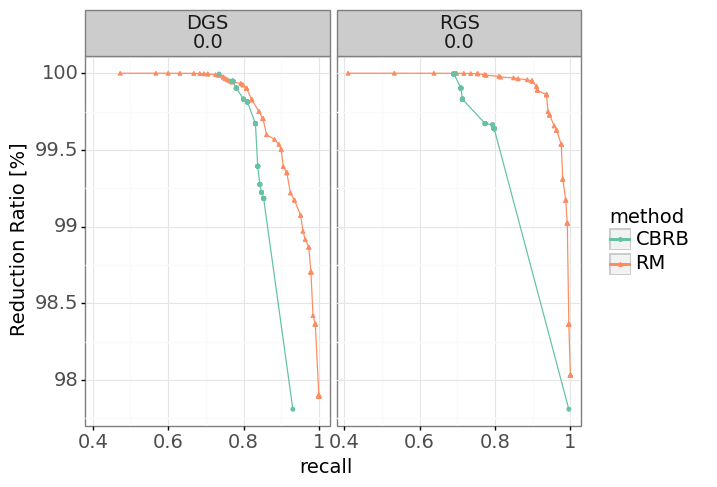

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rrParametrizedMissingValues.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

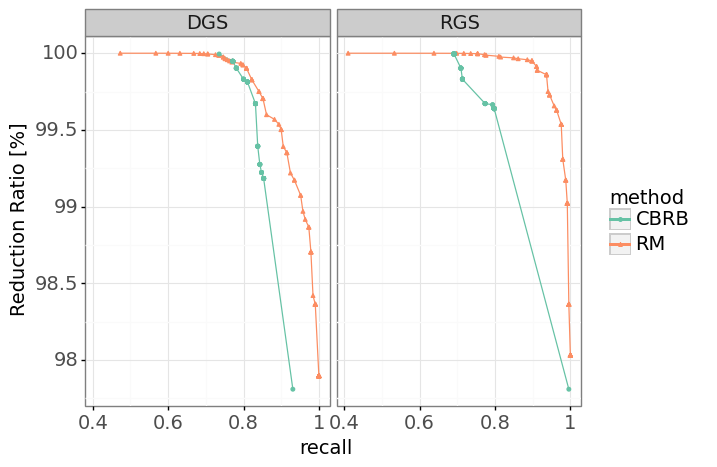

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exported_plots_new/parametrizedEvaluation.pdf
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [49]:
from plotnine import *

#we can never get worse in terms of reduction ratio if we choose less recall:
def createSmoothedRR(x, finalDF):
    gs = x["GS"]
    method = x["method"]
    dataset = x["dataset"]
    recall = x["recall"]
    synthData = x["gs"]
    sorted = finalDF[(finalDF["dataset"]==dataset) & (finalDF["method"]==method) & (finalDF["GS"]==gs)  & (finalDF["gs"]==synthData) & (finalDF["recall"]>=recall)].sort_values('rr',ascending=False)
    bestRR = sorted.iloc[0]["rr"]
    return bestRR

reductionRatioSmoothed = finalDF.apply(lambda x: createSmoothedRR(x,finalDF),axis=1)
finalDF["rrSmooth"] = reductionRatioSmoothed
finalDFMAA = finalDF[finalDF['dataset']=="MAA"]
#with missing values:
plot = ggplot(finalDFMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=1) + theme_bw() + facet_wrap(["GS","gs"]) + theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/rrParametrizedMissingValues.png")
#without missing values
finalDFMAANoMissing = finalDFMAA[finalDFMAA["gs"]==0.0]
plot = ggplot(finalDFMAANoMissing, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=1) + theme_bw() + facet_wrap("GS") + theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exported_plots_new/parametrizedEvaluation.pdf",width=leanPDFPlotWidth,height=leanPDFPlotHeight)

In [39]:
print(finalDFMAA[(finalDFMAA["method"]=="CBRB") & (finalDFMAA["recall"]>=0.79) & (finalDFMAA["GS"]=="RGS")])

                 n         rr method  threshold   gs dataset    recall   GS  \
1223  3.760635e+08  97.810446   CBRB       0.00  0.0     MAA  0.995920  RGS   
1235  1.553616e+08  99.161513   CBRB       0.01  0.0     MAA  0.797746  RGS   
1247  1.553616e+08  99.161513   CBRB       0.02  0.0     MAA  0.797746  RGS   
1259  1.553615e+08  99.161514   CBRB       0.03  0.0     MAA  0.797746  RGS   
1271  1.553589e+08  99.161523   CBRB       0.04  0.0     MAA  0.797746  RGS   
1283  1.553233e+08  99.161624   CBRB       0.05  0.0     MAA  0.797746  RGS   
1295  1.551653e+08  99.162037   CBRB       0.06  0.0     MAA  0.797746  RGS   
1307  1.548997e+08  99.162705   CBRB       0.07  0.0     MAA  0.797746  RGS   
1319  1.543215e+08  99.164176   CBRB       0.08  0.0     MAA  0.797746  RGS   
1331  1.538114e+08  99.165490   CBRB       0.09  0.0     MAA  0.797746  RGS   
1343  1.530283e+08  99.167571   CBRB       0.10  0.0     MAA  0.797746  RGS   
1355  1.518318e+08  99.170889   CBRB       0.11  0.0

# Print Parameter Settings

In [8]:
#print(finalDFMAA[(finalDFMAA['recall']>=0.95) & (finalDFMAA['GS']=="RGS")])
for gs in goldStandardMissingValues:
    print(gs)
    print(finalDFMAA[(finalDFMAA['method']=="RM") & (finalDFMAA['recall']>=0.69) & (finalDFMAA['GS']=="RGS") & (finalDFMAA['gs']==gs)].iloc[-1])
    print(finalDFMAA[(finalDFMAA['method']=="RM") & (finalDFMAA['recall']>=0.73) & (finalDFMAA['GS']=="DGS") & (finalDFMAA['gs']==gs)].iloc[-1])

0.5
n            166290.729504
rr               99.999376
method                  RM
threshold             0.91
gs                     0.5
dataset                MAA
recall            0.704657
GS                     RGS
rrSmooth         99.999376
Name: 5471, dtype: object
n            214505.680438
rr               99.999267
method                  RM
threshold              0.9
gs                     0.5
dataset                MAA
recall            0.734799
GS                     DGS
rrSmooth         99.999267
Name: 5410, dtype: object
0.6
n            166290.729504
rr               99.999376
method                  RM
threshold             0.91
gs                     0.6
dataset                MAA
recall            0.704657
GS                     RGS
rrSmooth         99.999376
Name: 5483, dtype: object
n            214505.680438
rr               99.999267
method                  RM
threshold              0.9
gs                     0.6
dataset                MAA
recall            0.734